<span style="font-size:250%">Analysis of results of iteration #1</span>

This repository documents the analysis of the results of the first iteration of the repository analysis. It is thus the base for all further evaluations. The documentation for the first analysis run can be found in the [RepoAnalysis](./RepoAnalysis.ipynb) notebook.

This notebook is composed as follows: The data is [preprocessed](#Preprocessing) for evaluation by calculating the deltas for each commit and joining with the commit size and author information. In the next section, [insights](#Data-Inspection) on the general quality of the data is aggregated - it needed to be improved. The following sections plot the data by [year](#Metrics-by-year), by [lifecycle](#Metrics-by-lifecycle), and by lifecycle in [boxplots](#Boxplots). The last section derives [statistical](#Statistical-test) insights with a Mann–Whitney U test.

All generated figures can be found unter [./results/figures_run_1](./results/figures_run_1).

In [2]:
%load_ext autoreload
%aimport dbUtils

In [7]:
import matplotlib.pyplot as pyplot

In [33]:
tableName = 'lb_results1'

First: How does the data look like? Looks alright, we see that at least for the shown commits, not much change happens. There are approx. 533k Tuples

In [3]:
dbUtils.runQuery('''
    SELECT *
    FROM crm20.'''+tableName+'''
''')

Time used: 3.5413761138916016


,sha,parent,timestamp,repoId,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,a3bfb67831d16a3dd03432a4430fc1d7fefc165a,55b899077ed33dd6a4044dfcefcab84eaded17d0,1398779561,9959521,19369,17157,107,1375,0,4788,10,1540,20181
1,ad62120b5dce822247ba584cc4b6b395a2714014,55b899077ed33dd6a4044dfcefcab84eaded17d0,1398779401,9959521,19369,17157,107,1375,0,4788,10,1540,20181
2,55b899077ed33dd6a4044dfcefcab84eaded17d0,d6665879a0e0cb92df49c4cc48311986f3313e63,1398776457,9959521,19369,17157,107,1375,0,4788,10,1540,20181
3,d6665879a0e0cb92df49c4cc48311986f3313e63,None,1398776134,9959521,19369,17157,107,1375,0,4788,10,1540,20181
4,658f1877cf54062dfb1fbe27ff3dda81a321a631,None,1398775888,9959521,19136,16952,105,1364,0,4737,10,1511,19744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
532883,d2cbd70d91ed44e3c5af95334d527ca03162cb35,0f0ad40bdaa570809b09850e77fe5bc76847dd78,1398786483,9959521,19110,16988,102,1357,0,4753,10,1540,19983
532884,0f0ad40bdaa570809b09850e77fe5bc76847dd78,None,1398785927,9959521,19110,16988,102,1357,0,4753,10,1540,19983
532885,da6bcff6c8754dc382f779a36a5099ee4bb9016c,bee939785ea9b5b180168299a6712087324eca32,1398785874,9959521,19110,16988,102,1357,0,4753,10,1540,19983
532886,bee939785ea9b5b180168299a6712087324eca32,39f617bf31b1c1d8735d90e44d05b5c702a0c52a,1398785659,9959521,19110,16988,102,1357,0,4753,10,1540,19983


# Preprocessing

The metrics as they are cannot be used for developer analysis and need to be refined.

## Deltas

The first thing to do is to determine the change for each commit so we can attribute this change to developers. Note the `DISTINCT` which avoids duplicates that come from forks being generated (thus making shas non-unique). Further note the `"` marks around some column names, these are needed as unknown column errors occur otherwise. In future iterations, the column name camel case has been replaced with snake case. This leaves us with approx. 292k commits, but the data set is reduced not only by duplicates, but also by merges (commits that have no unique parent).  

In [278]:
dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_deltas CASCADE;
    CREATE VIEW crm20.lb_deltas AS (
        SELECT DISTINCT
            child.sha, 
            child.timestamp,
            child.loc - parent.loc AS d_loc,
            child.cloc - parent.cloc AS d_cloc,
            child."fileCount" - parent."fileCount" AS d_filecount,
            child."numMethods" - parent."numMethods" AS d_methods,
            child."numLambdas" - parent."numLambdas" AS d_lambdas,
            child."numCommentLines" - parent."numCommentLines" AS d_commentlines,
            child."numReflection" - parent."numReflection" AS d_reflection,
            child."numSnakes" - parent."numSnakes" AS d_snakes,
            child."totalIndent" - parent."totalIndent" AS d_totalindent
        FROM 
            crm20.'''+tableName+''' child, crm20.'''+tableName+''' parent
        WHERE child.parent = parent.sha
    );
    SELECT * FROM crm20.lb_deltas
''')

Time used: 3.979785442352295


,sha,timestamp,d_loc,d_cloc,d_filecount,d_methods,d_lambdas,d_commentlines,d_reflection,d_snakes,d_totalindent
0,000022c4ccdf575e58a64ac0f023b0eaab4d9e64,1340672870,0,0,0,0,0,0,0,0,0
1,0000307741a8851a6c0c9a9b67aff772d3c37eb9,1487872565,0,0,0,0,0,0,0,0,0
2,00003958449875a674c7f8c79868aea2f85bc5c9,1417558244,52,52,0,5,0,17,0,0,129
3,000087d0ec3a5150cd62626532a55d2f9b01ac44,1433252442,283,205,2,12,0,0,1,16,315
4,00009c0342b0df015a14017a708b4e5ec488a441,1471423992,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
292047,fffe7b40da5717d7be0256e37a8739219a1656dc,1535565039,0,0,0,0,0,0,0,0,0
292048,fffea339744378acb9123521c384a1feb4663c73,1375451561,0,0,0,0,0,0,0,0,0
292049,ffff18107892f28b4bf9cbff5b873fb79cd3182b,1410152633,0,0,0,0,0,0,0,0,0
292050,ffff3f8ef96bbf873b08250fc70bc6c7ba4f0c3d,1051458026,0,0,0,0,0,0,0,0,0


## Adding GHTorrent data (developer and commit loc) 

To attribute the metric information to developers, it must be joined with the author information. To allow to reflect on the quality instead of the commits instead of their impact, changed loc is also needed. For now, data is joined with all java developers, and filtered later.

In [283]:
dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_delta_results CASCADE;
    
    CREATE VIEW crm20.lb_delta_results AS (
        SELECT
            lb_deltas.*, 
            TIMESTAMP 'epoch' + lb_deltas.timestamp * INTERVAL '1 second' as date,
            lb_java_users.first_written,
            lb_java_users.author_id,
            lb_java_changes.changes AS changes,
            lb_java_changes.deletions AS deletions
        FROM 
            crm20.lb_deltas, 
            crm20.lb_java_commits,
            crm20.lb_java_users,
            crm20.lb_java_changes
        WHERE lb_deltas.sha = lb_java_commits.sha
        AND lb_deltas.sha = lb_java_changes.sha
        AND lb_java_users.author_id = lb_java_commits.author_id
    );
    
    SELECT * FROM crm20.lb_delta_results
''')

Time used: 3.3452436923980713


,sha,timestamp,d_loc,d_cloc,d_filecount,d_methods,d_lambdas,d_commentlines,d_reflection,d_snakes,d_totalindent,date,first_written,author_id,changes,deletions
0,000087d0ec3a5150cd62626532a55d2f9b01ac44,1433252442,283,205,2,12,0,0,1,16,315,2015-06-02 13:40:42,2013-07-26 10:09:31,2192544,281,0
1,0003fef9ab586a6879bed31eed2b17d70e5040c9,1423257092,455,364,8,101,0,1,1,3,35,2015-02-06 21:11:32,2014-07-28 01:07:00,911011,1147,350
2,00052a0cacf3a5cde7e00cc92307684422ebd090,1343833520,59,0,0,0,0,0,0,0,0,2012-08-01 15:05:20,2009-02-27 14:23:06,512799,711,326
3,000bebb780311fe9b80e0743db009c16c6306745,1510269414,35,32,0,2,0,0,0,0,119,2017-11-09 23:16:54,2015-11-06 14:32:29,10337471,35,0
4,00116baebfd152e1e4df7835673d1f6fb443e862,1419119934,3,3,0,0,0,0,0,0,8,2014-12-20 23:58:54,2010-04-11 12:32:30,100236,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16214,ffeb2ea3f0e0803865aeab9378f2c035e3c65ed9,1440782569,192,185,0,7,0,38,1,4,520,2015-08-28 17:22:49,2014-07-20 17:43:33,4651311,206,7
16215,ffeccc846230d4cd8434b52970177c26d15ac5d5,1340474864,2,2,0,0,0,0,0,0,8,2012-06-23 18:07:44,2012-05-27 17:49:58,201710,6,2
16216,fff21be7f9ad1e800f56e7cf524a2b0a4b744bf0,1426978293,0,0,0,0,0,0,0,0,0,2015-03-21 22:51:33,2014-07-28 01:07:00,911011,6,3
16217,fffdd5712ac1a4a03ae91e18b546d3a5ea22b384,1479404863,15,15,0,1,0,-17,0,1,80,2016-11-17 17:47:43,2016-10-23 23:08:47,31888379,49,17


Are delta_results unique? (Because there were problems with shas not being unique due to forks) <br>
16219 = 16219 --> Yes, they are unique, adding `DISTINCT` to the query of `lb_deltas` has worked!

In [285]:
dbUtils.runQuery('''
    SELECT DISTINCT sha FROM crm20.lb_delta_results
''')

Time used: 3.2636446952819824


,sha
0,000087d0ec3a5150cd62626532a55d2f9b01ac44
1,0003fef9ab586a6879bed31eed2b17d70e5040c9
2,00052a0cacf3a5cde7e00cc92307684422ebd090
3,000bebb780311fe9b80e0743db009c16c6306745
4,00116baebfd152e1e4df7835673d1f6fb443e862
...,...
16214,ffeb2ea3f0e0803865aeab9378f2c035e3c65ed9
16215,ffeccc846230d4cd8434b52970177c26d15ac5d5
16216,fff21be7f9ad1e800f56e7cf524a2b0a4b744bf0
16217,fffdd5712ac1a4a03ae91e18b546d3a5ea22b384


# Data Inspection

The following section looks at how the collected data is constituded. This section evolved with new insights further down in the notebook. <br>
Note: With the current scaled-up dataset, the calculated number will vary, but the observed effects are expected to stay the same.


How man rows are there where we have a corresponding commit in ght.commits? <br>
--> 241535<br>
This means that we collect more data than we can actually process: because we do not have the author data for newer commits in the ghTorrent dataset, we cannot attribute the commit changes to authors. An approach would be to de-anonymize the users, but this is out of scope of this project.

In [290]:
dbUtils.runQuery('''
    SELECT DISTINCT commits.sha 
    FROM crm20.lb_deltas, ght.commits
    WHERE lb_deltas.sha = commits.sha
''')

Time used: 7.8981287479400635


,sha
0,000022c4ccdf575e58a64ac0f023b0eaab4d9e64
1,0000307741a8851a6c0c9a9b67aff772d3c37eb9
2,00003958449875a674c7f8c79868aea2f85bc5c9
3,000087d0ec3a5150cd62626532a55d2f9b01ac44
4,00009c0342b0df015a14017a708b4e5ec488a441
...,...
241530,fffe6ca1e02e9079989e2c0921cc2ea35dd0a542
241531,fffe7b40da5717d7be0256e37a8739219a1656dc
241532,fffea339744378acb9123521c384a1feb4663c73
241533,ffff18107892f28b4bf9cbff5b873fb79cd3182b


How many commits could we theoretically use if we didn't join over so many tables? <br>
--> 25640 <br>
So these are all the commits we can know the author and metrics of (and that have a relevant author)

In [6]:
dbUtils.runQuery('''
    SELECT
        COUNT(lb_deltas.sha)
    FROM crm20.lb_deltas, ght.commits
    WHERE lb_deltas.sha = commits.sha
    AND (
        author_id IN (SELECT author_id FROM crm20.lb_controlgroup)
        OR author_id IN (SELECT author_id FROM crm20.lb_polyglots)
    )
''')

Time used: 7.680671691894531


,count
0,25640


Let's have a comparing look at the sample commits where we have change information to (so those were we can actually reflect about the change, only knowing the author and metrics is not sufficient with the current methodology).

How many commits are there that are in our samples and java? (So assuming that the authors were relevant, how many commits could we maximally reflect on) <br>
--> 16260<br> 
So this is interesting! Because of the additional join with raw_patches that is included here, a lot of data is lost!<br>
This value is especially problematic in that this means there are on average only 80 commits er author - and there might be many authors with less <br>
This means that an alternative mean of calculating the changed loc of the commits needs to be found!

In [294]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_java_commits CASCADE;
    
    CREATE MATERIALIZED VIEW crm20.lb_java_commits AS (
        SELECT DISTINCT lb_sample_commits.*, lb_changes.loc
        FROM crm20.lb_sample_commits, crm20.lb_changes
        WHERE lb_sample_commits.sha = lb_changes.sha
        AND language = 'java'
    );
    
    SELECT * FROM crm20.lb_java_commits
''')

dbUtils.runQuery('''
    SELECT DISTINCT lb_java_commits.sha 
    FROM crm20.lb_deltas, crm20.lb_java_commits
    WHERE lb_deltas.sha = lb_java_commits.sha
''')

Time used: 3.090005874633789


,sha
0,000087d0ec3a5150cd62626532a55d2f9b01ac44
1,0003fef9ab586a6879bed31eed2b17d70e5040c9
2,00052a0cacf3a5cde7e00cc92307684422ebd090
3,000bebb780311fe9b80e0743db009c16c6306745
4,00116baebfd152e1e4df7835673d1f6fb443e862
...,...
16255,ffeb2ea3f0e0803865aeab9378f2c035e3c65ed9
16256,ffeccc846230d4cd8434b52970177c26d15ac5d5
16257,fff21be7f9ad1e800f56e7cf524a2b0a4b744bf0
16258,fffdd5712ac1a4a03ae91e18b546d3a5ea22b384


# Metrics by year

The intuition for reflecting about the impact of learning a new programming language is to see if the code quality changes when starting to learn it. Therefore, this sections shows early approaches to plot the metrics over time to get a general understanding of the collected data.

The following simply plots the data over year. For this averages of all commits (!) for each year are made. 

In [149]:
metricsByYear = dbUtils.runQuery('''
    SELECT
        EXTRACT(YEAR FROM date) as year, 
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results
    WHERE changes > 0
    GROUP BY year
    ORDER BY year
''')
display(metricsByYear)

Time used: 0.27174854278564453


,year,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,2003.0,360.474684,325.924051,1.949367,0.009011,-0.002122,0.002044,0.000581,0.011819,0.162520
1,2004.0,43.908333,37.958333,0.266667,0.005817,-0.004230,0.015715,0.000648,-0.002070,0.282066
2,2009.0,-27.784504,-22.548426,0.121065,0.014056,0.000118,-0.026212,0.001258,0.011432,0.122153
3,2010.0,398.320988,340.327160,3.981481,0.025931,-0.000051,0.033712,0.002672,0.012551,0.440605
4,2011.0,58.677848,48.219078,1.074074,0.024196,0.000014,0.025679,0.001611,0.023570,0.331840
5,2012.0,46.725801,39.805762,0.374555,0.015977,0.000075,0.029566,0.001388,0.015054,0.468809
6,2013.0,14.752167,19.356961,-7.831973,0.021804,0.000331,0.019817,0.001223,0.015442,0.625551
7,2014.0,-0.326818,0.353052,0.066015,0.024415,0.003848,0.025676,0.000391,0.027217,0.630343
8,2015.0,52.173188,43.379747,0.461450,0.023938,0.005634,0.021670,0.001089,0.028836,0.576614
9,2016.0,101.451934,90.998158,0.471087,0.019661,0.003020,0.032344,0.009056,0.046487,0.798806


Some things can be derived from this:
* There seems to be some extreme value in 2010 for loc and in 2013 for filecount
* Reflection only got popular after 2014 which might imply that there are some developers that joined at that point
* Most metrics gradually increase. This is unexpected and might be an error in calculating commit quality

Generally, a larger dataset might help to noise out the outlyers and smoothen up the curves to get more firm results

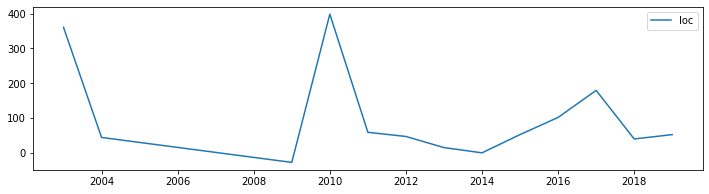

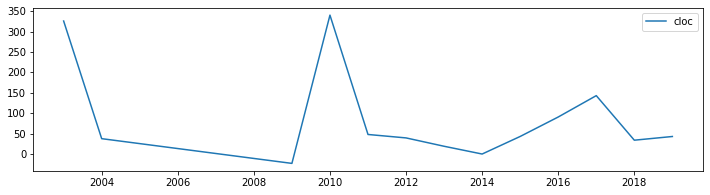

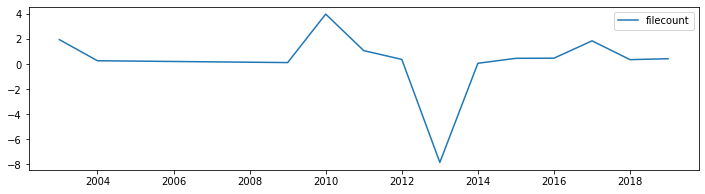

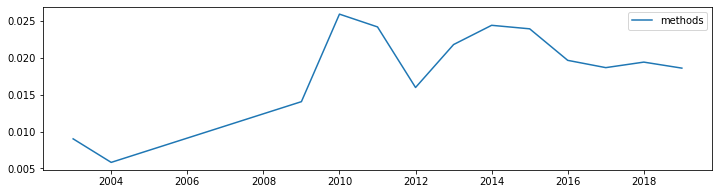

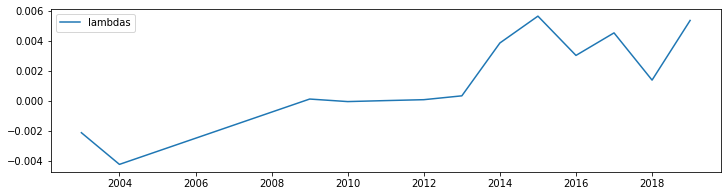

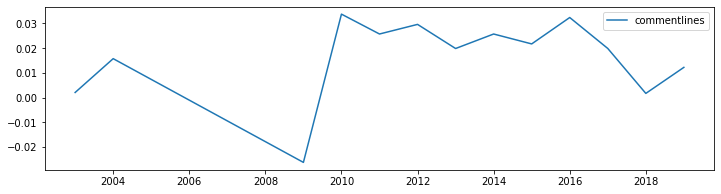

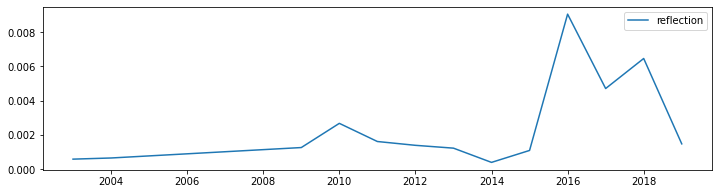

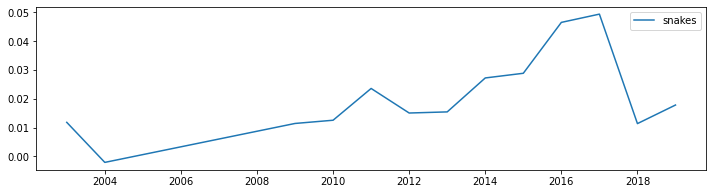

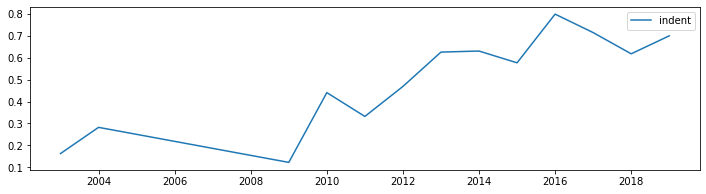

In [150]:
for metric in metricsByYear:
    if metric == 'year': continue 
    pyplot.figure(figsize=(12, 3))
    pyplot.plot(metricsByYear['year'], metricsByYear[metric])
    pyplot.legend([metric])

# Metrics by lifecycle

However, to compare developers, a lifecycle approach seems promising: This filters out when developers started their careers. To avoid too strong noise, aggregation into "phases" has proven itself. This means that the lifecycle is divided into constant size intervals and values are averaged for those intervals for each developer (which is better than for each commit, because otherwise developers with more commits would be weighted heigher).

In [346]:
lifecylePhases = 20.0
percentPerPhase = 100.0 / lifecylePhases
lifecycle = ('''FLOOR(EXTRACT(EPOCH FROM ((date - first_written))) / EXTRACT(EPOCH FROM ((TIMESTAMP '2020-1-1 00:00:00') - first_written)) * '''
             +str(lifecylePhases)+''') * '''+str(percentPerPhase)+''' as lifecycle''')

In [347]:
metricsByLifecycle = dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_metrics_by_lifecycle;
    CREATE VIEW crm20.lb_metrics_by_lifecycle AS (
        SELECT
            author_id,
            '''+lifecycle+''',
            MIN(date) AS date,
            AVG(CAST(d_loc AS DECIMAL)) AS loc,
            AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
            AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
            AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
            AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
            AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
            AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
            AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
            AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
        FROM crm20.lb_delta_results
        WHERE changes > 0
        AND changes < 1000
        AND ABS(d_loc) < 1000
        GROUP BY lifecycle, author_id
        ORDER BY lifecycle
    );
    SELECT * FROM crm20.lb_metrics_by_lifecycle
''')
display(metricsByLifecycle)

Time used: 3.040175437927246


,author_id,lifecycle,date,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,16503,0.0,2010-10-04 08:24:53,70.750000,61.750000,0.250000,0.006484,0.000000,0.146106,0.000000,0.002855,0.905079
1,34131,0.0,2010-07-22 19:35:29,78.048780,56.512195,0.536585,0.017424,0.000032,0.039384,0.003889,0.019069,0.508483
2,89727,0.0,2012-03-01 14:56:58,20.900000,15.400000,0.600000,0.014665,0.000000,0.034000,0.000055,0.038012,0.875659
3,100236,0.0,2010-04-11 20:04:49,35.857143,30.714286,0.285714,0.017977,0.000000,0.052613,0.002976,0.005013,0.433354
4,105547,0.0,2012-06-18 05:43:37,27.072289,23.036145,0.337349,0.054451,0.000000,0.006704,0.002130,0.034874,0.460618
...,...,...,...,...,...,...,...,...,...,...,...,...
571,911011,85.0,2019-04-12 23:40:20,-23.900000,-20.800000,-0.200000,-0.021673,-0.012881,0.067729,0.000000,0.135294,0.621598
572,2104969,85.0,2019-04-19 13:32:14,43.727273,35.145455,0.527273,0.017303,0.009347,-0.009220,-0.000239,0.010407,0.460839
573,89727,90.0,2019-03-21 09:23:29,12.533333,13.333333,0.000000,0.020492,-0.006684,0.000519,0.000271,0.024188,0.470825
574,512799,90.0,2018-12-10 12:02:40,5.800000,4.828571,0.057143,0.027120,0.045469,0.005192,0.002389,-0.002033,0.762341


## All java devs

I again plotted these for all java developers to see if there are general insights. 
* It is interesting to see, that in later phases developers seem to produce less code. This could for example be explained by the increased complexity of projects or the conciseness of the code of experienced developers
* Method size and lambdas go up strongly in the last phases which is definitively an outlier in the data, late digging has shown that there is too view developers in the last phases, as there are some developers that stopped their career before the lifecylce end date. As at that point only the first written date but not the last written was recorded, this could be fixed
* High fluctuations might indicate that the lifecycle intervals are dominated by extreme values

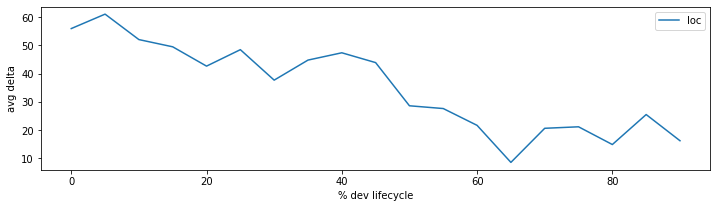

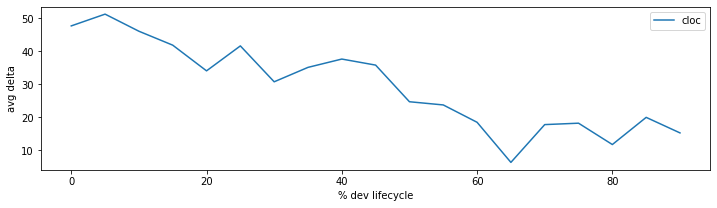

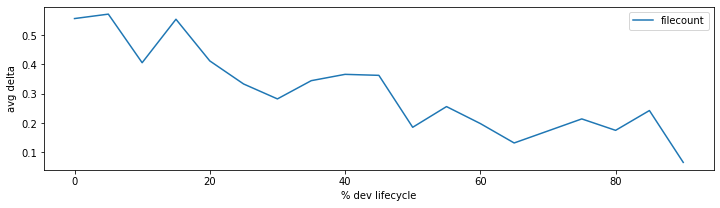

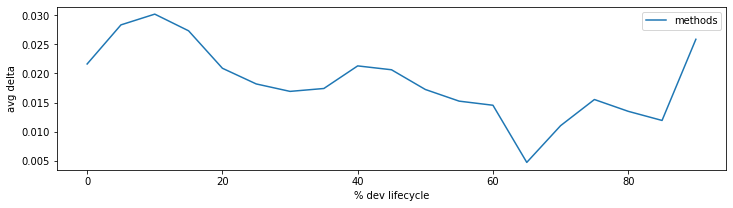

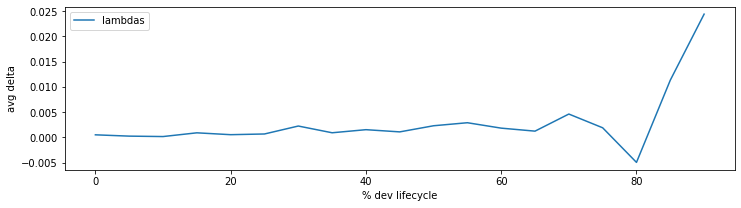

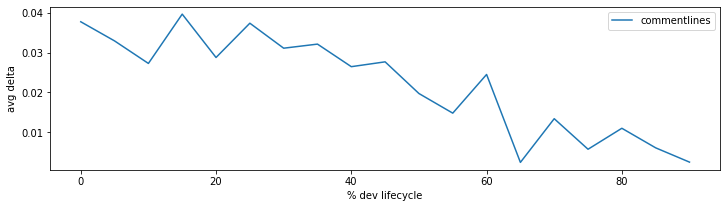

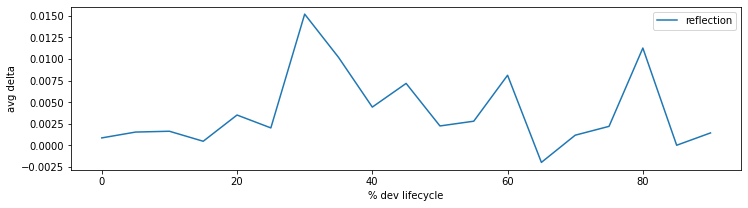

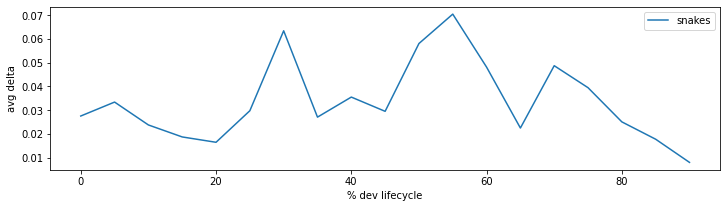

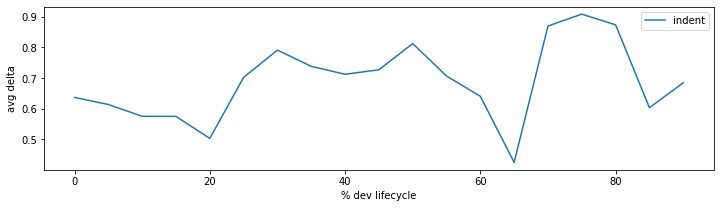

In [311]:
for metric in metricsByLifecycle:
    if metric == 'lifecycle': continue 
    pyplot.figure(figsize=(12, 3))
    pyplot.xlabel('% dev lifecycle')
    pyplot.ylabel('avg delta')
    pyplot.plot(metricsByLifecycle['lifecycle'], metricsByLifecycle[metric])
    pyplot.legend([metric])

## Experiment groups

The actual interesting thing was to see the difference between the two experiment groups: polyglots and control group. Polyglot data is filtered by the date of the first write of secondary language, but to see if there is a difference, the whole data is also created

In [351]:
metricsPolyglot = dbUtils.runQuery('''
    SELECT
        lifecycle,      
        AVG(loc) AS loc,
        AVG(cloc) AS cloc,
        AVG(filecount) AS filecount,
        AVG(methods) AS methods,
        AVG(lambdas) AS lambdas,
        AVG(commentlines) AS commentlines,
        AVG(reflection) AS reflection,
        AVG(snakes) AS snakes,
        AVG(indent) AS indent
    FROM crm20.lb_metrics_by_lifecycle, crm20.lb_polyglots
    WHERE lb_polyglots.author_id = lb_metrics_by_lifecycle.author_id
    AND date > ALL(secstart)
    GROUP BY lifecycle
    ORDER BY lifecycle
''')
display(metricsPolyglot)

Time used: 3.024366855621338


,lifecycle,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,0.0,156.200000,132.000000,0.600000,0.008201,0.000409,0.020872,0.000136,0.004562,0.976512
1,0.0,-14.000000,-13.571429,0.142857,-0.003662,0.000000,-0.096582,0.000000,0.004008,0.003499
2,0.0,17.250000,11.250000,0.000000,0.004902,0.006654,0.009804,0.000000,-0.002852,0.530439
3,0.0,1.000000,0.857143,0.000000,0.000000,0.000000,0.011145,0.000000,0.000000,0.239683
4,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
217,85.0,22.166667,18.666667,0.166667,0.016725,0.002381,0.059016,0.000000,0.020572,0.658917
218,85.0,43.727273,35.145455,0.527273,0.017303,0.009347,-0.009220,-0.000239,0.010407,0.460839
219,90.0,12.533333,13.333333,0.000000,0.020492,-0.006684,0.000519,0.000271,0.024188,0.470825
220,90.0,5.800000,4.828571,0.057143,0.027120,0.045469,0.005192,0.002389,-0.002033,0.762341


In [338]:
metricsPolyglotFull = dbUtils.runQuery('''
    SELECT
        lifecycle,      
        AVG(loc) AS loc,
        AVG(cloc) AS cloc,
        AVG(filecount) AS filecount,
        AVG(methods) AS methods,
        AVG(lambdas) AS lambdas,
        AVG(commentlines) AS commentlines,
        AVG(reflection) AS reflection,
        AVG(snakes) AS snakes,
        AVG(indent) AS indent
    FROM crm20.lb_metrics_by_lifecycle, crm20.lb_polyglots
    WHERE lb_polyglots.author_id = lb_delta_results.author_id
    AND date < ALL(secstart)
    GROUP BY lifecycle
    ORDER BY lifecycle
''')
#display(metricsPolyglotFull)

ProgrammingError: (psycopg2.errors.UndefinedTable) missing FROM-clause entry for table "lb_delta_results"
LINE 14:     WHERE lb_polyglots.author_id = lb_delta_results.author_i...
                                            ^

[SQL: 
    SELECT
        lifecycle,      
        AVG(loc) AS loc,
        AVG(cloc) AS cloc,
        AVG(filecount) AS filecount,
        AVG(methods) AS methods,
        AVG(lambdas) AS lambdas,
        AVG(commentlines) AS commentlines,
        AVG(reflection) AS reflection,
        AVG(snakes) AS snakes,
        AVG(indent) AS indent
    FROM crm20.lb_metrics_by_lifecycle, crm20.lb_polyglots
    WHERE lb_polyglots.author_id = lb_delta_results.author_id
    AND date < ALL(secstart)
    GROUP BY lifecycle
    ORDER BY lifecycle
]
(Background on this error at: http://sqlalche.me/e/f405)

In [352]:
metricsControlGroup = dbUtils.runQuery('''
    SELECT
        lifecycle,      
        AVG(loc) AS loc,
        AVG(cloc) AS cloc,
        AVG(filecount) AS filecount,
        AVG(methods) AS methods,
        AVG(lambdas) AS lambdas,
        AVG(commentlines) AS commentlines,
        AVG(reflection) AS reflection,
        AVG(snakes) AS snakes,
        AVG(indent) AS indent
    FROM crm20.lb_metrics_by_lifecycle
    WHERE author_id IN (SELECT author_id FROM crm20.lb_controlgroup)
    GROUP BY lifecycle
    ORDER BY lifecycle
''')
display(metricsControlGroup)

Time used: 2.9888861179351807


,lifecycle,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,0.0,70.750000,61.750000,0.250000,0.006484,0.000000,0.146106,0.000000,0.002855,0.905079
1,0.0,78.048780,56.512195,0.536585,0.017424,0.000032,0.039384,0.003889,0.019069,0.508483
2,0.0,105.750000,92.750000,1.250000,0.031427,0.000000,0.018952,0.018973,0.199918,0.398565
3,0.0,155.214286,137.357143,1.428571,0.021730,-0.000218,0.099952,0.000000,0.020288,0.611693
4,0.0,133.600000,117.700000,2.800000,0.027867,0.000000,0.121932,0.001639,0.029828,1.257094
...,...,...,...,...,...,...,...,...,...,...
211,75.0,-58.761905,-50.047619,-0.428571,0.001414,-0.001505,-0.005468,-0.001601,0.005527,-0.147341
212,80.0,-107.166667,-93.666667,-0.500000,-0.043493,-0.001565,0.007565,0.165493,-0.000044,1.122675
213,80.0,44.500000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
214,80.0,4.000000,6.000000,0.000000,0.000000,0.000000,0.130435,0.000000,0.000000,0.304348


Plotting the metrics shows differences between the two groups. However, it is hard to visually derive "evidence" for effects from this diagrams

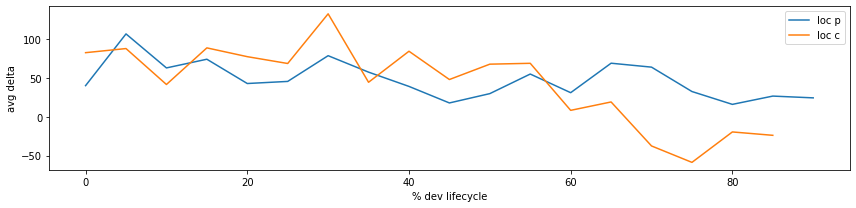

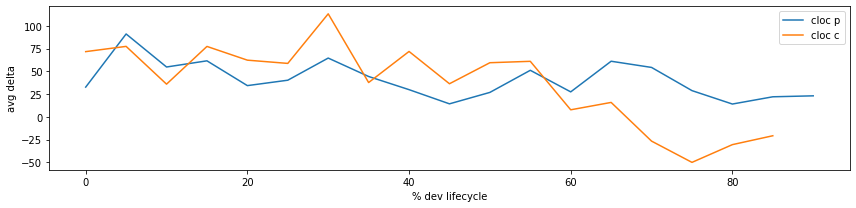

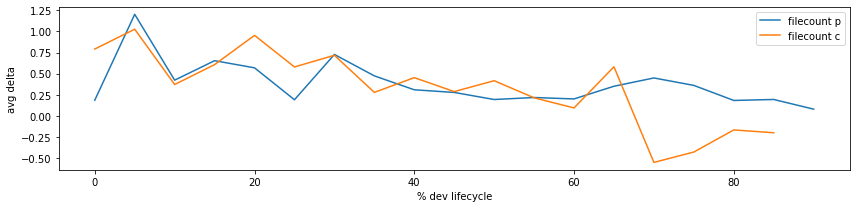

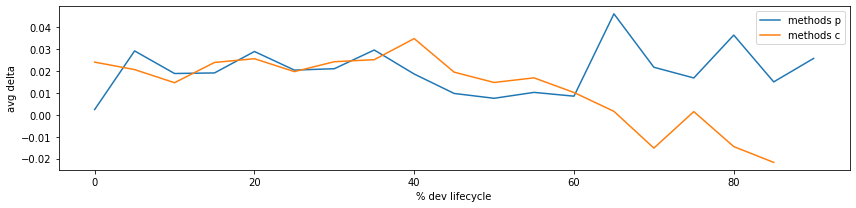

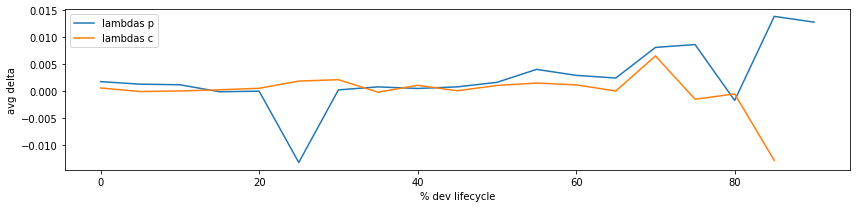

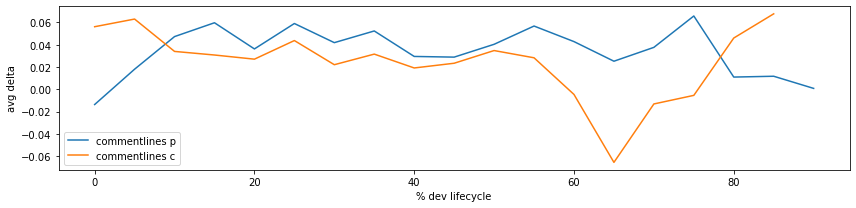

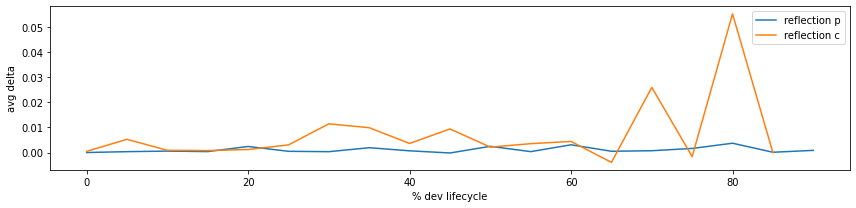

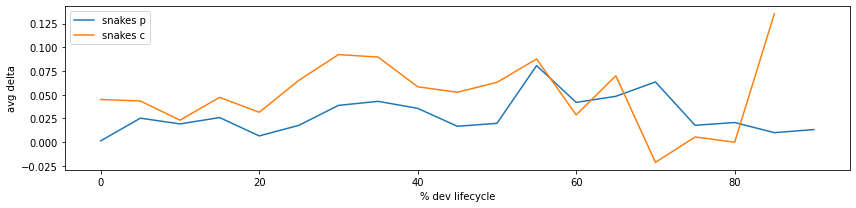

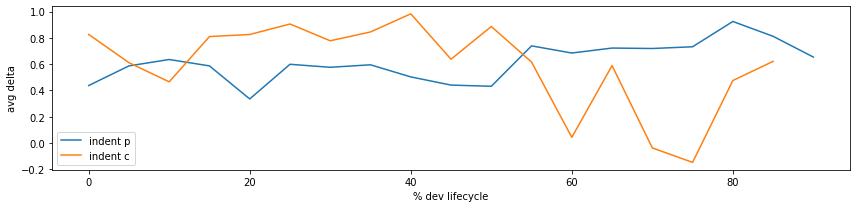

In [350]:
for metric in metricsPolyglot:
    if metric == 'lifecycle': continue 
    pyplot.figure(figsize=(12, 3))
    pyplot.xlabel('% dev lifecycle')
    pyplot.ylabel('avg delta')
    pyplot.plot(metricsPolyglot['lifecycle'], metricsPolyglot[metric])
    pyplot.plot(metricsControlGroup['lifecycle'], metricsControlGroup[metric])
    #pyplot.plot(metricsPolyglotFull['lifecycle'], metricsPolyglotFull[metric])
    pyplot.legend([metric+' p', metric+' c'])
    pyplot.tight_layout()
    pyplot.savefig('figures/'+metric+'.png')

# Boxplots

As curve plots give a wrong impression of continuity and hide the important aspect of how the data is composed, boxplots have been chosen as alternative visualization form.

While those plots did not help to prove effects, they showed that data on a lifecycle basis might be too extreme and that a more generalized approach on both groups might be needed. This could however be revisited with a scaled-up dataset.

Note: Some of the boxplots show weird empty boxes and their medians do not always match those calculated above. The reason for this was never found because I quickly moved on after feedback on the lifecycle approach.

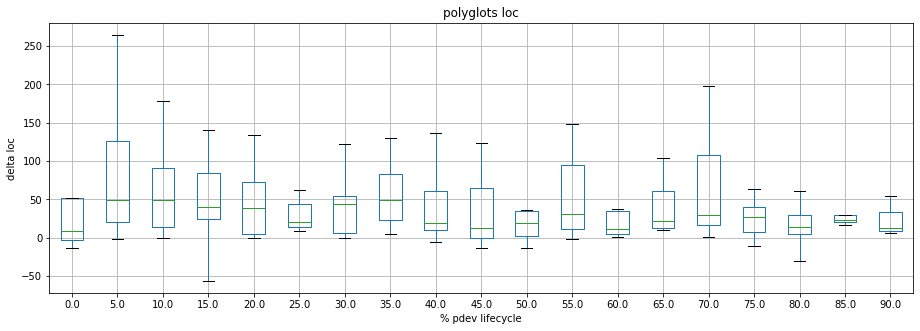

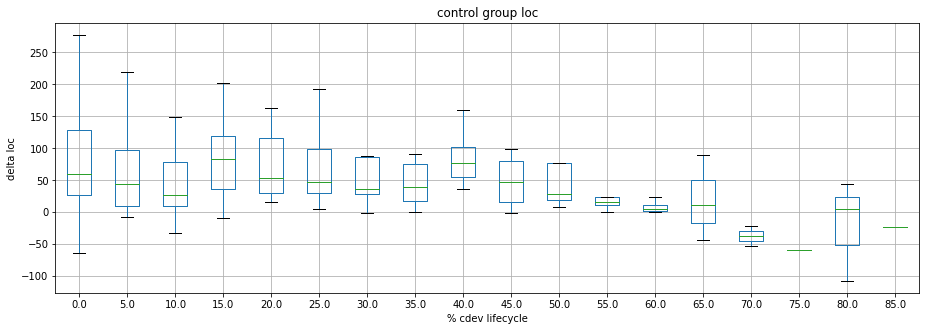

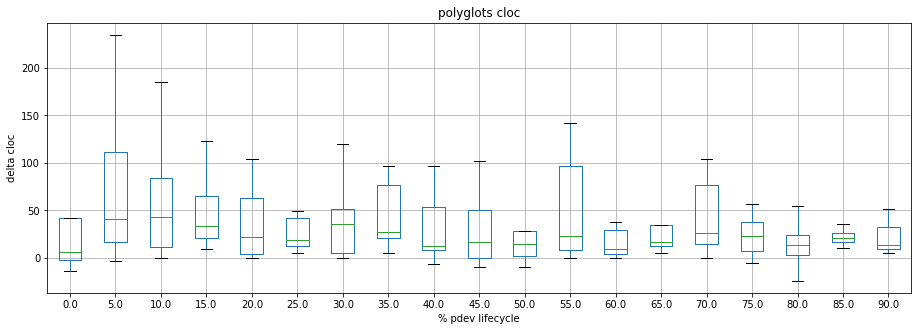

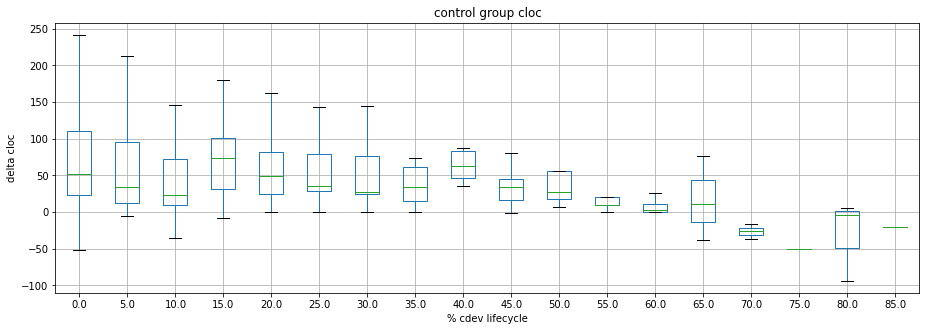

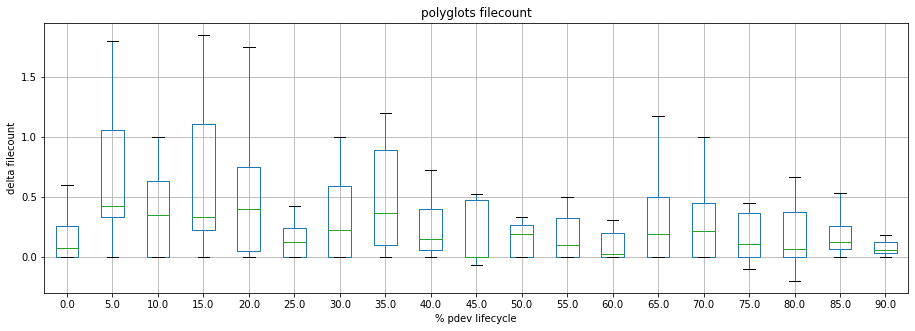

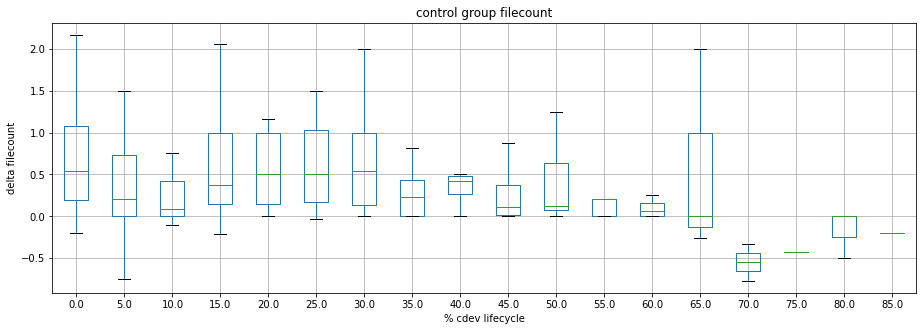

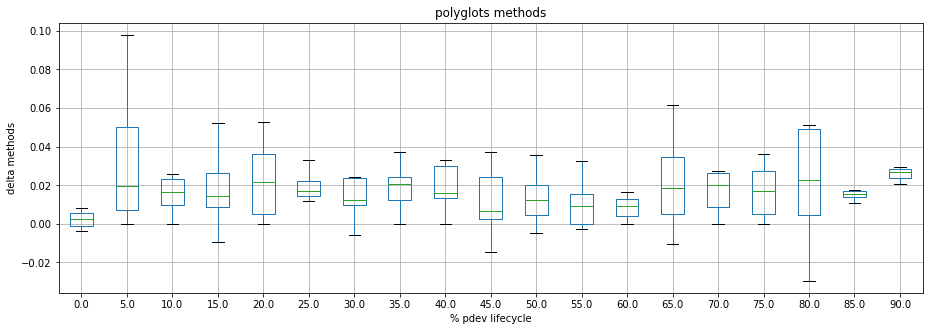

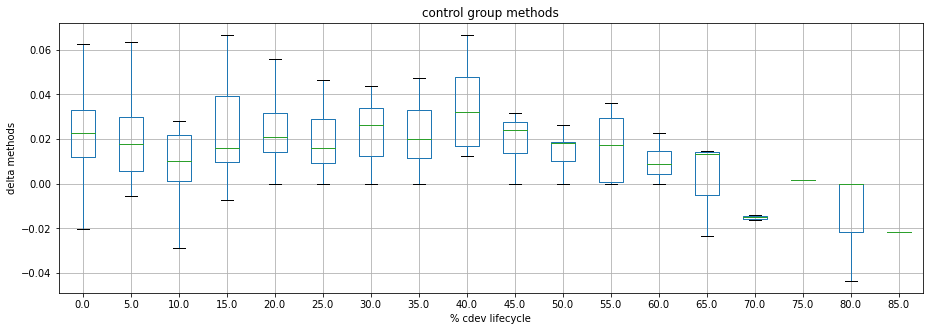

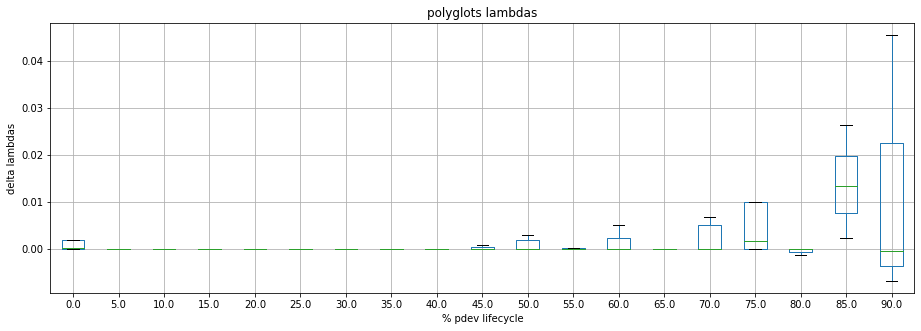

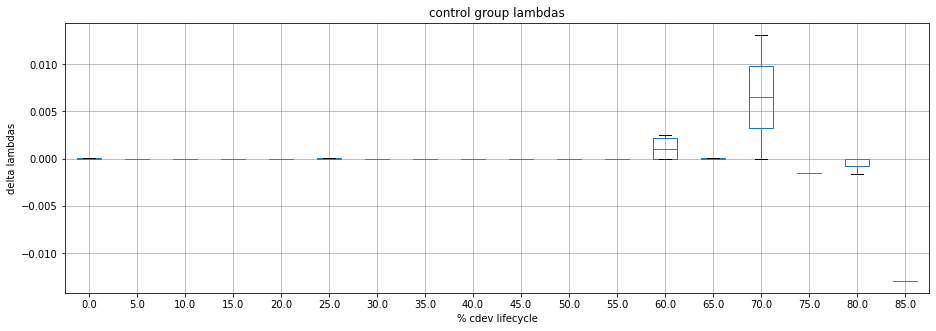

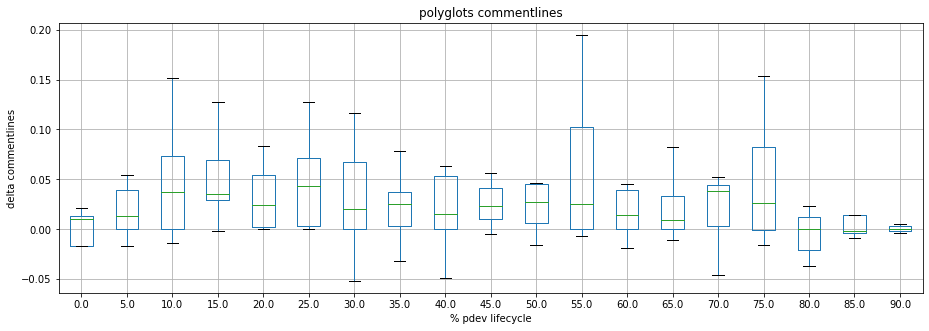

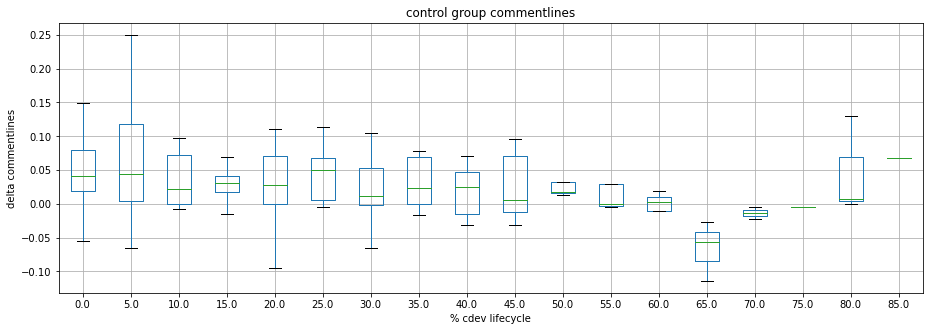

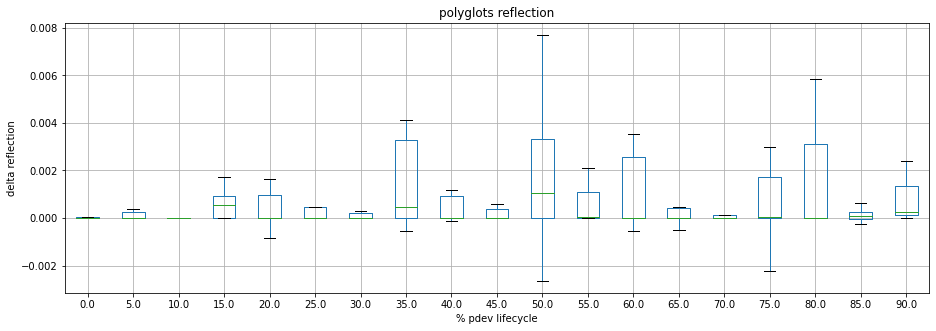

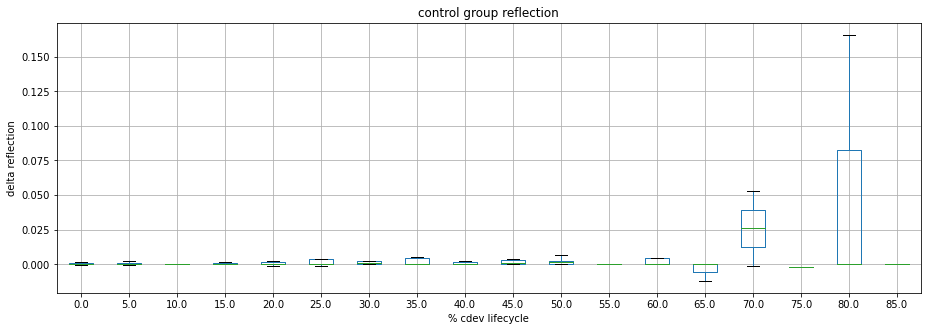

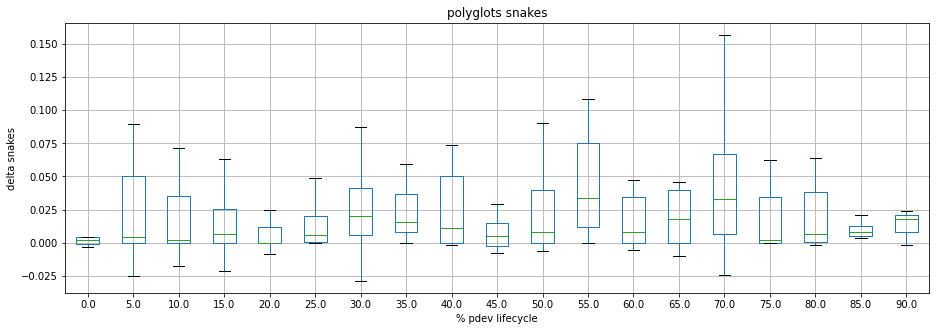

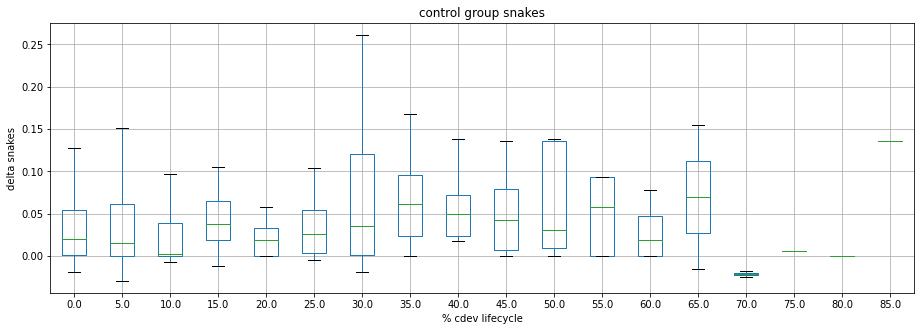

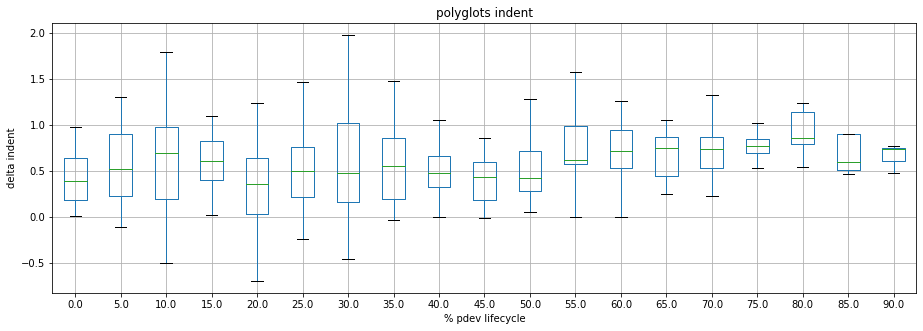

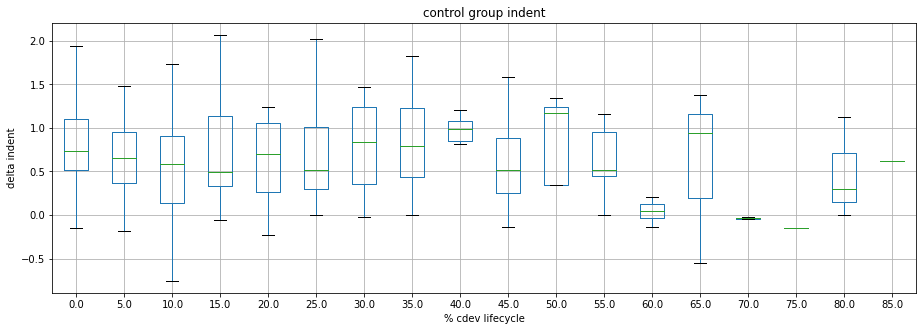

In [353]:
for metric in metricsPolyglot:
    if metric == 'lifecycle': continue 
    
    x = metricsPolyglot.boxplot(column=metric, by='lifecycle', showfliers=False, figsize=(15, 5))
    pyplot.xlabel('% pdev lifecycle')
    pyplot.ylabel('delta '+metric)
    pyplot.title('polyglots '+metric)
    pyplot.suptitle('')
    
    y = metricsControlGroup.boxplot(column=metric, by='lifecycle', showfliers=False, figsize=(15, 5))
    pyplot.xlabel('% cdev lifecycle')
    pyplot.ylabel('delta '+metric)
    pyplot.title('control group '+metric)
    pyplot.suptitle('')

# Statistical Testing

To take a step back from the lifecycles which provided good initial insights, but lead to no solid results, the overall groups are now compared. For this purpose, boxplots again have been chosen as visualization means, but additionally statistical tests are employed.

## Data selections

Data now is collected for each developer on average over their whole lifespan.

In [9]:
boxDataPolyglot = dbUtils.runQuery('''
    SELECT
        author_id,
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results
    WHERE author_id IN (SELECT author_id FROM crm20.lb_polyglots)
    AND changes > 0
    AND changes < 1000
    AND ABS(d_loc) < 1000
    GROUP BY author_id
''', mute=True)
display(boxDataPolyglot)

,author_id,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,55149,47.467213,36.959016,1.000000,0.040381,0.000676,0.048772,0.000015,0.008653,0.760567
1,61025,69.830645,57.403226,0.411290,0.010847,0.000000,0.036841,0.001549,0.034085,0.350930
2,89727,18.122596,16.598558,0.165865,0.019881,0.000699,0.000890,0.007281,0.017468,0.719038
3,100010,177.875000,153.875000,1.625000,0.014358,0.000000,0.058727,0.000000,0.038762,1.791663
4,100236,20.821546,16.379112,0.222451,0.010703,0.000076,0.012832,0.000819,0.037654,0.894512
...,...,...,...,...,...,...,...,...,...,...
83,40957194,60.000000,53.375000,0.375000,0.029015,0.000000,0.060037,0.000000,0.000000,1.260066
84,45852806,45.562500,38.187500,0.437500,0.002825,0.000000,0.023700,0.000000,0.000706,0.282374
85,45985807,134.250000,104.000000,2.250000,0.133414,0.000000,0.040728,0.000000,0.000000,0.398359
86,46354752,40.817391,40.095652,-0.008696,0.014855,0.000308,0.005688,0.000000,0.020656,0.517421


In [10]:
boxDataControlGroup = dbUtils.runQuery('''
    SELECT
        author_id,
        AVG(CAST(d_loc AS DECIMAL)) AS loc,
        AVG(CAST(d_cloc AS DECIMAL)) AS cloc,
        AVG(CAST(d_filecount AS DECIMAL)) AS filecount,
        AVG(CAST(d_methods AS DECIMAL)/changes) AS methods,
        AVG(CAST(d_lambdas AS DECIMAL)/changes) AS lambdas,
        AVG(CAST(d_commentlines AS DECIMAL)/changes) AS commentlines,
        AVG(CAST(d_reflection AS DECIMAL)/changes) AS reflection,
        AVG(CAST(d_snakes AS DECIMAL)/changes) AS snakes,
        AVG(CAST(d_totalindent AS DECIMAL)/changes) AS indent
    FROM crm20.lb_delta_results
    WHERE author_id IN (SELECT author_id FROM crm20.lb_controlgroup)
    AND changes > 0
    AND changes < 1000
    AND ABS(d_loc) < 1000
    GROUP BY author_id
''', mute=True)
display(boxDataControlGroup)

,author_id,loc,cloc,filecount,methods,lambdas,commentlines,reflection,snakes,indent
0,16503,50.166667,44.166667,0.166667,0.004323,0.000000,0.097404,0.000000,0.001903,-0.082328
1,34131,85.508143,60.488599,0.889251,0.023174,0.000025,0.073661,0.001605,0.031147,0.619316
2,99671,88.300000,73.900000,0.600000,0.013922,0.000000,0.036423,0.000000,0.104998,0.568016
3,153911,105.750000,92.750000,1.250000,0.031427,0.000000,0.018952,0.018973,0.199918,0.398565
4,402963,141.000000,127.270270,1.081081,0.018232,0.001366,0.089895,-0.000059,0.015641,0.524642
...,...,...,...,...,...,...,...,...,...,...
76,42150587,46.562500,38.062500,0.187500,0.014097,0.000000,0.012505,0.000000,0.002418,0.318202
77,43589755,101.500000,91.500000,0.500000,0.028972,0.000000,0.065471,0.000000,0.243118,1.836066
78,43643543,197.615385,168.461538,0.923077,0.018152,0.000423,0.176076,0.000000,0.036983,1.301872
79,50518011,43.833333,38.166667,0.250000,0.050543,0.000000,0.019445,0.000000,0.021277,1.305537


## Plotting

Plotting the data now clearer shows the differences between the two groups while also highlighting the high variance in values.

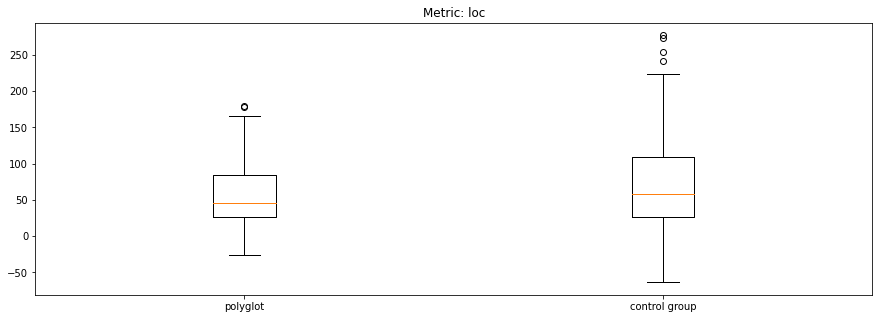

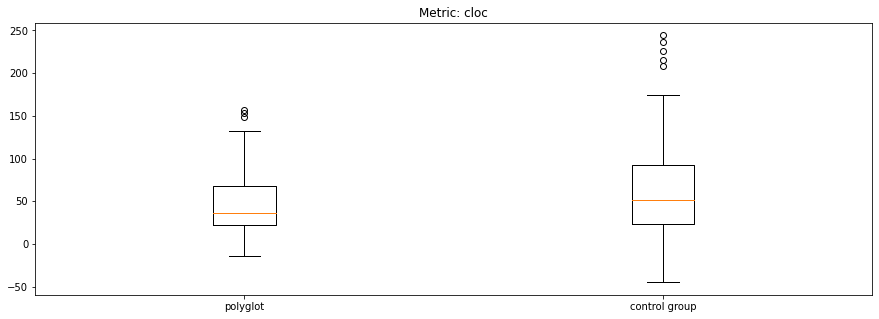

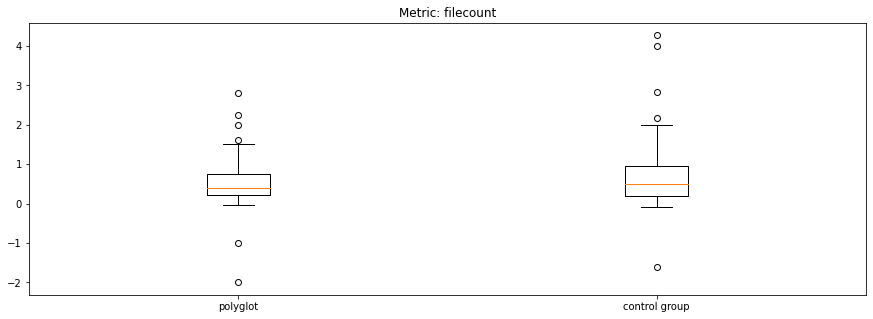

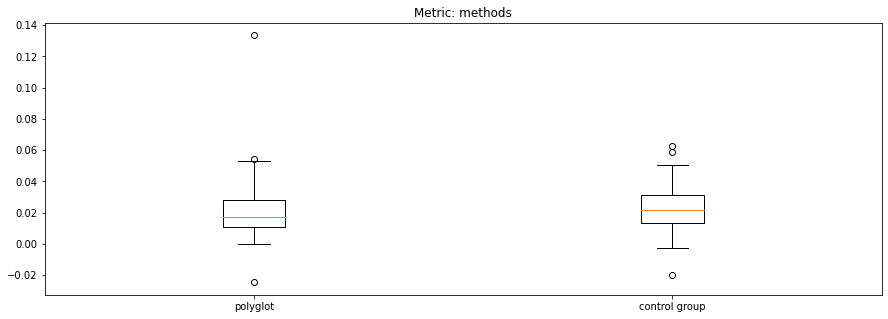

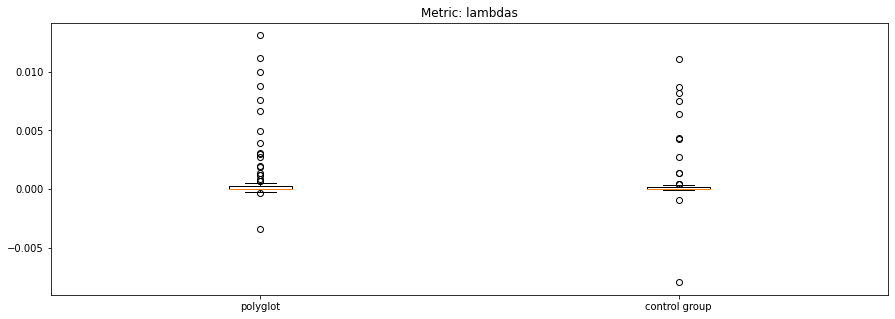

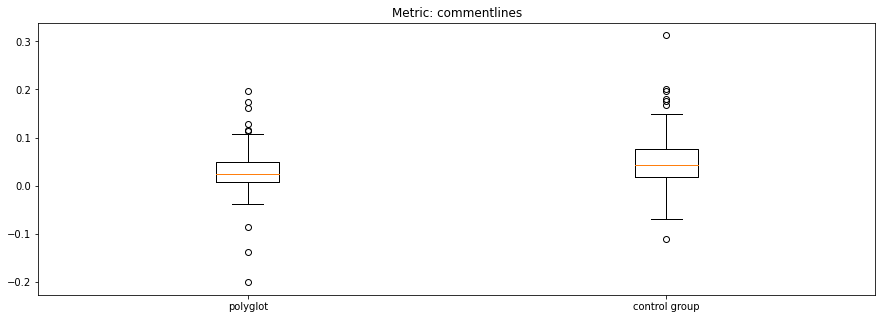

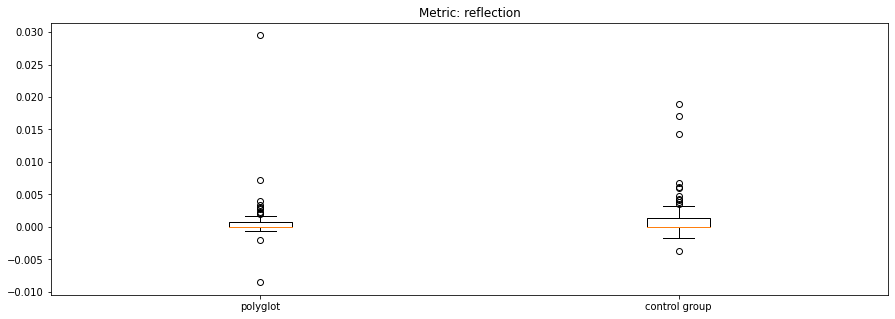

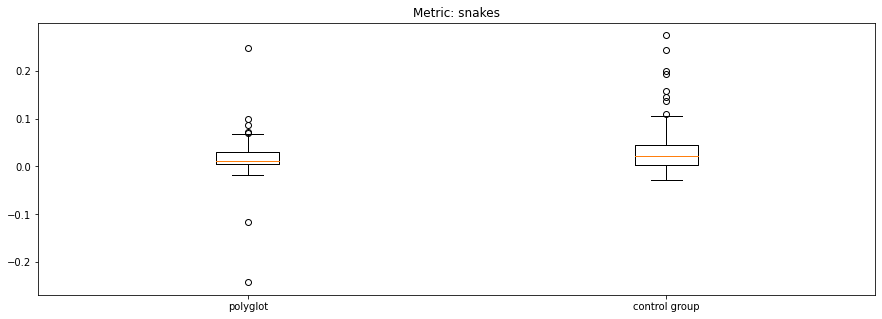

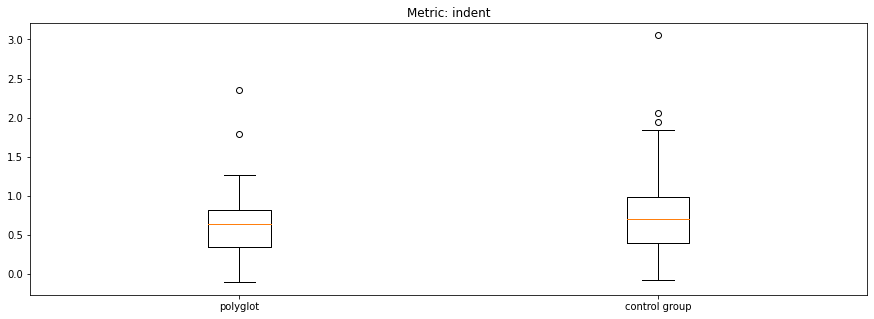

In [17]:
for metric in boxDataPolyglot:
    if metric == 'author_id': continue 
        
    pyplot.figure(figsize=(15, 5))
    pyplot.title('Metric: '+metric)
    pyplot.boxplot([boxDataPolyglot[metric], boxDataControlGroup[metric]], labels=['polyglot', 'control group'])
    pyplot.savefig('figures/boxplot_'+metric+'.png')

## Statistical test

We now apply a Mann–Whitney U test to see how high the probability is that the measured effects are only randomness. As threshold for significance, 5% is used.

In [29]:
from scipy.stats import mannwhitneyu

for metric in boxDataPolyglot:
    if metric == 'author_id': continue 
    pvalue = mannwhitneyu(boxDataPolyglot[metric], boxDataControlGroup[metric]).pvalue
    print((metric+': ').ljust(15)+str(pvalue)+'\t '+str(pvalue < 0.05))

loc:           0.039412809834279104	 True
cloc:          0.03316304305439506	 True
filecount:     0.17212059256554657	 False
methods:       0.10152195085238341	 False
lambdas:       0.4364791264261678	 False
commentlines:  0.010318818579783454	 True
reflection:    0.3474597881670489	 False
snakes:        0.08542488071423093	 False
indent:        0.04814278224404524	 True


The test shows that there are positive results for the metrics loc (and class loc), density of comment lines and average indent. While indent is not surprising as Python developers are included into the set, the others are. It is important to note that these effects must not necessarily come from the influence of learning a new language, but might also for example be expression of a different mindset of polyglot programmers.

Additionally, snake case usage and method length are candidates that might change on a larger dataset. As this is just a first run with a relatively small data set (especially the number of available commits per author are problematic) this test will be rerun (despite the scientifical sin that is commited by this). 